Black-Scholes Price (European): 10.4506
Binomial Tree Price (European): 10.4306
Monte Carlo Price (European): 10.3857
Binomial Tree Price (American): 6.0824


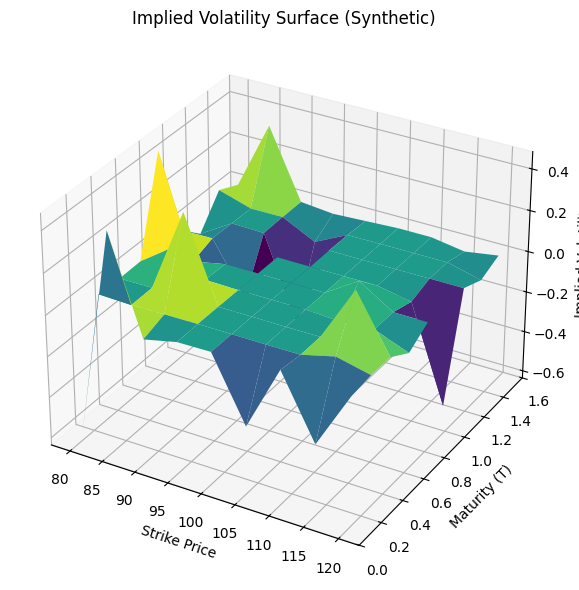

In [ ]:
# 📈 Options Pricing Engine in Python

import numpy as np
import scipy.stats as si
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Option Class to store parameters
class Option:
    def __init__(self, S, K, T, r, sigma, option_type='call', style='european'):
        self.S = S            # Spot Price
        self.K = K            # Strike Price
        self.T = T            # Time to Maturity (in years)
        self.r = r            # Risk-free interest rate
        self.sigma = sigma    # Volatility
        self.option_type = option_type.lower()   # 'call' or 'put'
        self.style = style.lower()               # 'european' or 'american'

# -----------------------------------------------
# 1️⃣ Black-Scholes Model (European only)
# -----------------------------------------------
def black_scholes(option: Option):
    S, K, T, r, sigma = option.S, option.K, option.T, option.r, option.sigma
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option.option_type == 'call':
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    return price

# -----------------------------------------------
# 2️⃣ Binomial Tree (European or American)
# -----------------------------------------------
def binomial_tree(option: Option, N=100):
    S, K, T, r, sigma = option.S, option.K, option.T, option.r, option.sigma
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Step 1: Calculate option value at maturity
    prices = np.zeros(N + 1)
    option_values = np.zeros(N + 1)

    for i in range(N + 1):
        prices[i] = S * (u ** (N - i)) * (d ** i)
        if option.option_type == 'call':
            option_values[i] = max(0, prices[i] - K)
        else:
            option_values[i] = max(0, K - prices[i])

    # Step 2: Backward induction
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            option_values[i] = np.exp(-r * dt) * (p * option_values[i] + (1 - p) * option_values[i + 1])

            # If American, check early exercise
            if option.style == 'american':
                price = S * (u ** (j - i)) * (d ** i)
                intrinsic = (price - K) if option.option_type == 'call' else (K - price)
                option_values[i] = max(option_values[i], intrinsic)

    return option_values[0]

# -----------------------------------------------
# 3️⃣ Monte Carlo Simulation (European only)
# -----------------------------------------------
def monte_carlo(option: Option, n_simulations=100000):
    S, K, T, r, sigma = option.S, option.K, option.T, option.r, option.sigma

    Z = np.random.standard_normal(n_simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)

    if option.option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# -----------------------------------------------
# 2️⃣ Implied Volatility (Root Finder)
# -----------------------------------------------
def implied_volatility(option: Option, market_price, sigma_bounds=(1e-5, 3)):
    def objective(sigma):
        option.sigma = sigma
        return black_scholes(option) - market_price
    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan

# -----------------------------------------------
# 3️⃣ Volatility Surface (Synthetic Example)
# -----------------------------------------------
def generate_vol_surface(S, r):
    strikes = np.linspace(80, 120, 9)
    maturities = np.linspace(0.1, 1.5, 9)
    vol_surface = np.zeros((len(maturities), len(strikes)))

    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            # Generate synthetic market prices (use a fixed sigma)
            option = Option(S=S, K=K, T=T, r=r, sigma=0.2, option_type='call')
            market_price = black_scholes(option)

            # Now pretend we only know price, and recover implied vol
            implied_vol = implied_volatility(option, market_price)
            vol_surface[i, j] = implied_vol

    return strikes, maturities, vol_surface

# -----------------------------------------------
# 4️⃣ Plotting Volatility Surface
# -----------------------------------------------
def plot_vol_surface(strikes, maturities, vol_surface):
    X, Y = np.meshgrid(strikes, maturities)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, vol_surface, cmap='viridis')
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Maturity (T)")
    ax.set_zlabel("Implied Volatility")
    ax.set_title("Implied Volatility Surface (Synthetic)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# 🔍 Example Usage
# -----------------------------------------------

option = Option(S=100, K=100, T=1, r=0.05, sigma=0.2, option_type='call', style='european')

bs_price = black_scholes(option)
bt_price_eur = binomial_tree(option, N=100)
mc_price = monte_carlo(option, n_simulations=100000)

print("Black-Scholes Price (European):", round(bs_price, 4))
print("Binomial Tree Price (European):", round(bt_price_eur, 4))
print("Monte Carlo Price (European):", round(mc_price, 4))

# For American Option (only Binomial Tree supports)
american_option = Option(S=100, K=100, T=1, r=0.05, sigma=0.2, option_type='put', style='american')
bt_price_am = binomial_tree(american_option, N=100)
print("Binomial Tree Price (American):", round(bt_price_am, 4))

strikes, maturities, vol_surface = generate_vol_surface(S, r)
plot_vol_surface(strikes, maturities, vol_surface)
